---
# I. DOWNLOAD & IMPORT & LIB INITIAL
---

In [ ]:
# Install
!python -m spacy download en_core_web_sm --quiet
!pip install -q sentence-transformers scikit-learn xgboost
!pip install pdfplumber python-docx spacy --quiet

# Import
# --- general ---
import pandas as pd
import numpy as np
import os
import re
import glob
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import json

# --- import for part 3 ---
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # for saving models

# --- import for part 4 ---
from google.colab import files
import pdfplumber
import docx

# --- import for part 6: question generation ---
import kagglehub
from kagglehub import KaggleDatasetAdapter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


---
II. DOWNLOAD & IMPORT & LIB INITIAL
---

In [ ]:
# Skill bank
def load_skills_from_json(skill_path):
    with open(skill_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, list):
        return set(data)
    elif isinstance(data, dict) and "skills" in data:
        return set(data["skills"])
    else:
        raise ValueError("Invalid JSON format: must be a list or dict with 'skills' key")


skill_path = "/content/dataset/skill_list.json"
SKILL_LIST = load_skills_from_json(skill_path)

# JD data
JOB_DESCRIPTION = """
We are seeking a Junior Mobile Developer to join our dynamic team.
Responsibilities include:
- Developing and maintaining mobile applications on Android and iOS platforms.
- Working with backend services and databases (MySQL, MongoDB, Firebase).
- Collaborating with UI/UX designers to deliver high-quality products.
- Using Git for version control and participating in Agile/Scrum development processes.

Requirements:
- Strong knowledge of Java, Kotlin, or Swift.
- Familiarity with REST APIs and JSON.
- Experience with cloud services like AWS or Azure is a plus.
- Good problem-solving and communication skills.
"""

# Resume data
resume_df = pd.read_csv("/content/dataset/resume.csv")
resume_texts = resume_df['Resume_str'].dropna().tolist()  # drop rows with missing values

In [ ]:
# ============================================
# HANLE JOB DESCRIPTION DATA
# ============================================
# Download NLTK resources
for pkg in ['punkt', 'punkt_tab', 'stopwords']:
    nltk.download(pkg, quiet=True)
from nltk.corpus import stopwords

# Load spaCy English model (load once, reuse)
nlp = spacy.load("en_core_web_sm")

# Prepare stopwords once
STOP_WORDS = set(stopwords.words('english'))

# Precompute lowercase skill map for faster case-insensitive matching
SKILL_BANK_LOWER = {s.lower(): s for s in SKILL_LIST}

def advanced_text_processing(text, auto_stopwords=None):
    """Process text: tokenize, remove stopwords, NER, skill extraction"""
    text_str = str(text) if not pd.isna(text) else ""
    text_lower = text_str.lower()

    # Tokenization + clean
    tokens = [w for w in nltk.word_tokenize(re.sub(r'[^\w\s]', ' ', text_lower))
              if w not in STOP_WORDS and (not auto_stopwords or w not in auto_stopwords)]

    # NER (using original text for better recognition)
    doc = nlp(text_str)
    ner_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Skill extraction (case insensitive)
    found_skills = {SKILL_BANK_LOWER[s] for s in SKILL_BANK_LOWER if s in text_lower}

    return {
        "tokens": tokens,
        "ner_entities": ner_entities,
        "skills": sorted(found_skills)
    }

# Function to analyze job description text
# Hàm để phân tích nội dung mô tả công việc (Job Description)
def analyze_job_description(jd_text, auto_stopwords=None):
    # Reuse the common text processing pipeline
    # Sử dụng lại pipeline xử lý văn bản chung
    return advanced_text_processing(jd_text, auto_stopwords=auto_stopwords)

# Analyze JD
# Phân tích JD
jd_result = analyze_job_description(JOB_DESCRIPTION)
#print("jd_result: ", jd_result)

                                             cv_text
0           ACCOUNTANT       Summary    To achiev...
1           CONSTRUCTION FOREMAN           Summar...
[VI] Bảng features sau khi trích xuất:
[EN] Features table after extraction:


,num_skills_cv,num_skills_jd,matched_count,match_ratio,tfidf_sim,emb_sim,cv_len_tokens,jd_len_tokens
0,8,21,7,0.33,0.144767,0.198081,835,86
1,3,21,1,0.05,0.338445,0.222669,737,86
2,3,21,3,0.14,0.326316,0.127686,768,86
3,0,21,0,0.00,0.000000,0.026001,2,86
4,0,21,0,0.00,0.000000,0.046827,1,86


[VI] Áp dụng PCA: 8 -> 4 chiều
[EN] Applied PCA: 8 -> 4 dimensions

[VI] Huấn luyện mô hình: Logistic Regression...
[EN] Training model: Logistic Regression...
Accuracy: 0.5009
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       279
           1       0.51      0.34      0.41       286

    accuracy                           0.50       565
   macro avg       0.50      0.50      0.49       565
weighted avg       0.50      0.50      0.49       565


[VI] Huấn luyện mô hình: Random Forest...
[EN] Training model: Random Forest...
Accuracy: 0.5168
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       279
           1       0.52      0.51      0.52       286

    accuracy                           0.52       565
   macro avg       0.52      0.52      0.52       565
weighted avg       0.52      0.52      0.52       565


[VI] Huấn luyện mô hình: Neural Network (MLP)...
[EN] Training model: 

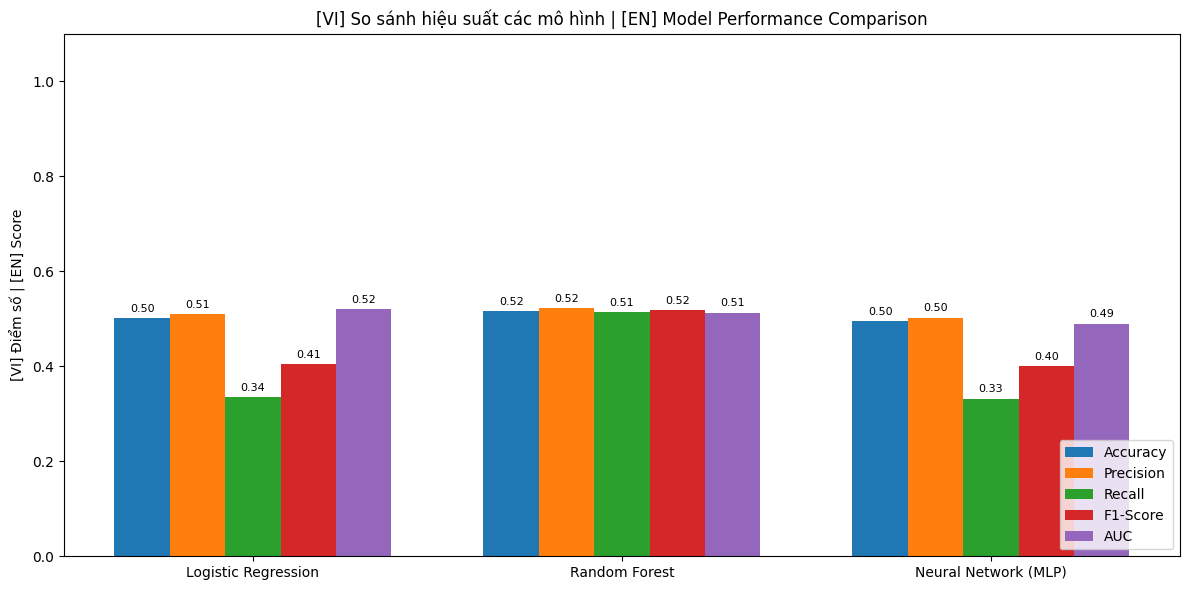

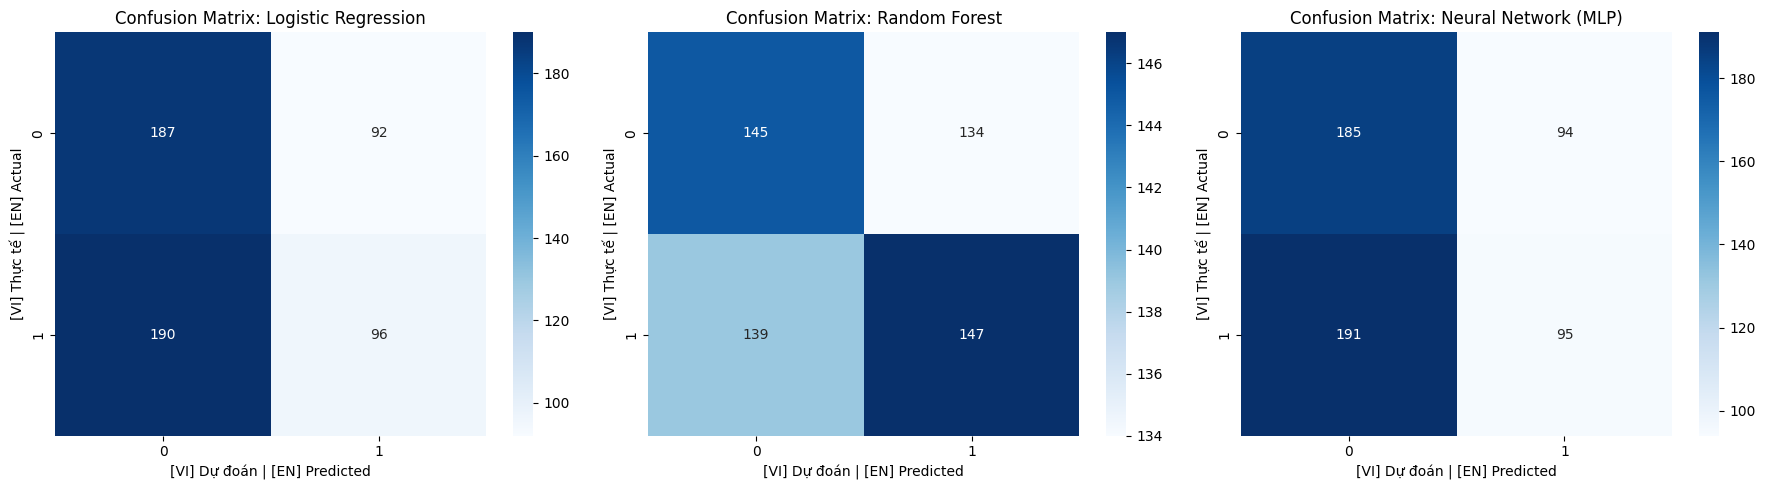

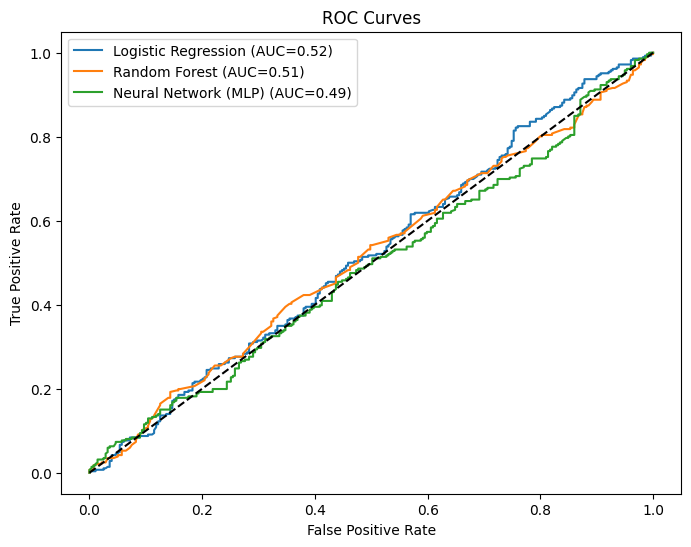


[VI] Mô hình tốt nhất (dựa trên F1-Score) là: Random Forest
[EN] The best model (based on F1-Score) is: Random Forest


In [ ]:
# ============================================
# PART 3 2: TRAINING & INFERENCE PIPELINE (Colab)
# Phần 3: Huấn luyện & suy luận
# ============================================
# [VI] Mô hình embedding, giữ nguyên
# [EN] Embedding model, unchanged
EMBED_MODEL = SentenceTransformer('all-MiniLM-L6-v2')

def match_cv_jd(cv_skills, jd_skills, threshold=0.65):
    """
    Match CV skills with JD skills (hybrid: lexical + semantic).
    Each CV-skill can match with at most one JD-skill (best match).
    """

    if not cv_skills or not jd_skills:
        return 0, 0.0, [], jd_skills

    matched = []
    matched_jd = set()

    # Encode all skills once
    cv_embeddings = EMBED_MODEL.encode(cv_skills, convert_to_tensor=True)
    jd_embeddings = EMBED_MODEL.encode(jd_skills, convert_to_tensor=True)

    # Similarity matrix (|cv| x |jd|)
    sim_matrix = util.cos_sim(cv_embeddings, jd_embeddings).cpu().numpy()

    for i, cv in enumerate(cv_skills):
        # best JD for this CV skill
        j_best = sim_matrix[i].argmax()
        semantic = sim_matrix[i][j_best].item()
        lexical = cv.lower() == jd_skills[j_best].lower()

        if lexical or semantic >= threshold:
            matched.append((cv, jd_skills[j_best], round(semantic, 2)))
            matched_jd.add(jd_skills[j_best].lower())

    matched_count = len(matched_jd)
    total = len(jd_skills)
    match_ratio = round(matched_count / total, 2) if total > 0 else 0.0

    missing_skills = [jd for jd in jd_skills if jd.lower() not in matched_jd]

    return matched_count, match_ratio, matched, missing_skills


# ============================================
# Helper functions
# ============================================
def tfidf_cosine_similarity(text_a, text_b, vectorizer=None):
    # [VI] TF-IDF cosine similarity
    # [EN] TF-IDF cosine similarity
    if vectorizer is None:
        vectorizer = TfidfVectorizer(lowercase=True)
        X = vectorizer.fit_transform([text_a, text_b])
    else:
        X = vectorizer.transform([text_a, text_b])
    v0 = X[0].toarray()[0]
    v1 = X[1].toarray()[0]
    denom = (np.linalg.norm(v0) * np.linalg.norm(v1) + 1e-9)
    return float(np.dot(v0, v1)/denom), vectorizer

def embedding_similarity(text_a, text_b, model=EMBED_MODEL):
    # [VI] Sentence-transformer cosine similarity
    # [EN] Sentence-transformer cosine similarity
    emb_a = model.encode(text_a, convert_to_tensor=True)
    emb_b = model.encode(text_b, convert_to_tensor=True)
    sim = util.cos_sim(emb_a, emb_b).item()
    return float(sim)

def build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer=None):
    cv_text_str = str(cv_text) if not pd.isna(cv_text) else ""
    jd_text_str = str(jd_text) if not pd.isna(jd_text) else ""
    # [VI] Xây dựng vector đặc trưng cho một cặp CV-JD
    # [EN] Build feature vector for a single CV-JD pair
    num_skills_cv = len(cv_skills)
    num_skills_jd = len(jd_skills)
    matched_count, match_ratio, matched_list, missing_list = match_cv_jd(cv_skills, jd_skills)
    tfidf_sim, vectorizer = tfidf_cosine_similarity(" ".join(cv_skills) + " " + cv_text_str,
                                                    " ".join(jd_skills) + " " + jd_text_str,
                                                    vectorizer=vectorizer)
    emb_sim = embedding_similarity(cv_text_str, jd_text_str)
    cv_len_tokens = len(re.findall(r'\w+', cv_text_str))
    jd_len_tokens = len(re.findall(r'\w+', jd_text_str))

    features = {
        "num_skills_cv": num_skills_cv,
        "num_skills_jd": num_skills_jd,
        "matched_count": matched_count,
        "match_ratio": match_ratio,
        "tfidf_sim": tfidf_sim,
        "emb_sim": emb_sim,
        "cv_len_tokens": cv_len_tokens,
        "jd_len_tokens": jd_len_tokens,
    }
    meta = {"matched_list": matched_list, "missing_list": missing_list}
    return features, vectorizer, meta

# ============================================
# [VI] Pipeline chính: HUẤN LUYỆN & ĐÁNH GIÁ
# [EN] Main Pipeline: TRAINING & EVALUATION
# ============================================
def train_and_evaluate_models(X, y, models, test_size=0.4):
    """
    [VI] Huấn luyện và đánh giá nhiều mô hình trên cùng một tập dữ liệu.
    [EN] Train and evaluate multiple models on the same dataset.
    """
    # [VI] Chuẩn hóa dữ liệu trước khi huấn luyện
    # [EN] Standardize the data before training
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # [VI] Giảm chiều dữ liệu bằng PCA (nếu cần)
    # [EN] Reduce data dimensionality with PCA (if needed)
    # PCA giúp mô hình Neural Network hoạt động tốt hơn với ít đặc trưng hơn
    # PCA helps the Neural Network model perform better with fewer features
    if X_scaled.shape[1] > 5: # Chỉ áp dụng PCA nếu có nhiều hơn 5 đặc trưng
        pca = PCA(n_components=0.95) # giữ lại 95% phương sai
        X_pca = pca.fit_transform(X_scaled)
        print(f"[VI] Áp dụng PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} chiều")
        print(f"[EN] Applied PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} dimensions")
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=test_size, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=42
        )

    results = {}
    for name, model in models.items():
        print(f"\n[VI] Huấn luyện mô hình: {name}...")
        print(f"[EN] Training model: {name}...")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # [VI] Đánh giá
            # [EN] Evaluation
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

            print(f"Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))

            results[name] = {
                "model": model,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "fscore": fscore,
                "auc": auc,
                "y_pred": y_pred,
                "y_test": y_test,
                "X_test_transformed": X_test,
                "scaler": scaler,
                "pca": pca if 'pca' in locals() else None
            }
        except Exception as e:
            print(f"[VI] Lỗi khi huấn luyện mô hình {name}: {e}")
            print(f"[EN] Error training model {name}: {e}")

    return results

# ============================================
# VISUALIZATION FUNCTIONS
# [VI] CÁC HÀM TRỰC QUAN HÓA
# ============================================
def visualize_results(results):
    """
    [VI] Trực quan hóa các kết quả đánh giá của các mô hình.
    [EN] Visualize the evaluation results of the models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
    model_names = list(results.keys())
    scores = {
        "Accuracy": [results[name]["accuracy"] for name in model_names],
        "Precision": [results[name]["precision"] for name in model_names],
        "Recall": [results[name]["recall"] for name in model_names],
        "F1-Score": [results[name]["fscore"] for name in model_names],
        "AUC": [results[name]["auc"] for name in model_names],
    }

    x = np.arange(len(model_names))
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (metric, values) in enumerate(scores.items()):
        rects = ax.bar(x + (i - 2) * width, values, width, label=metric)
        autolabel(rects, ax)

    ax.set_ylabel("[VI] Điểm số | [EN] Score")
    ax.set_title("[VI] So sánh hiệu suất các mô hình | [EN] Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend(loc='lower right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

def autolabel(rects, ax):
    """[VI] Ghi số lên đầu các cột | [EN] Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

def plot_confusion_matrix(y_true, y_pred, title, ax):
    """
    [VI] Vẽ ma trận nhầm lẫn
    [EN] Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("[VI] Dự đoán | [EN] Predicted")
    ax.set_ylabel("[VI] Thực tế | [EN] Actual")


# ============================================
# EXECUTION
# [VI] THỰC THI
# ============================================
# [VI] ...
# [EN] Build df_pairs by the resume_texts have extracted from the previous part
# (Code để tạo df_cv đã có trong phần trước)
# --- Step 1: Load CV dataset ---
df_cv = pd.DataFrame({'cv_text': resume_texts})
df_cv = df_cv.sample(min(2000, len(df_cv)), random_state=42).reset_index(drop=True)
print(df_cv.head(2))

# --- Step 2: Tạo các cặp CV-JD & gán nhãn [label] cho từng cặp ---
pairs = []
for idx, cv in df_cv.iterrows():
    threshold = 0.3  # tỉ lệ trùng >= 30% thì xem là match
    cv_text = cv['cv_text']

    cv_skills = advanced_text_processing(cv_text)["skills"]
    jd_skills = jd_result["skills"]

    # Tính số skill trùng và tỉ lệ
    matched_count, match_ratio, matched_list, missing_list = match_cv_jd(cv_skills, jd_skills)

    # Tạo các đặc trưng cần thiết để gán nhãn
    cv_len_tokens = len(re.findall(r'\w+', cv_text))
    jd_len_tokens = len(re.findall(r'\w+', JOB_DESCRIPTION))
    emb_sim = embedding_similarity(cv_text, JOB_DESCRIPTION) # Tính emb_sim ở đây

    if match_ratio >= 0.5:
        label = 1
    elif emb_sim > 0.8 and match_ratio >= 0.1:
        label = 1
    elif len(matched_list) >= 3 and jd_len_tokens > 100:
        label = 1
    else:
        label = 0

    pairs.append({
        "cv_text": cv_text,
        "cv_skills": cv_skills,
        "jd_text": JOB_DESCRIPTION,
        "jd_skills": jd_result["skills"],
        "label": label
    })

df_pairs = pd.DataFrame(pairs)  # <-- convert to DataFrame

# [VI] Xây dựng features cho toàn bộ dữ liệu
# [EN] Build features for the entire dataset
feature_rows = []
vectorizer = None
metas = []
for idx, row in df_pairs.iterrows():
    feats, vectorizer, meta = build_features_single(
        row.cv_text,
        row.cv_skills,
        row.jd_text,
        row.jd_skills,
        vectorizer=vectorizer
    )
    feature_rows.append(feats)
    metas.append(meta)

X = pd.DataFrame(feature_rows)
y = df_pairs['label'].values

print("[VI] Bảng features sau khi trích xuất:")
print("[EN] Features table after extraction:")
display(X.head())

# [VI] Định nghĩa các mô hình bạn đã học
# [EN] Define the models you have studied
models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42),
}

from sklearn.metrics import roc_curve
def plot_roc_curves(results):
    plt.figure(figsize=(8,6))
    for name, res in results.items():
        model = res['model']
        X_test = res['X_test_transformed']  # đã scale/PCA
        try:
            y_proba = model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(res['y_test'], y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.2f})")
        except:
            continue
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

# [VI] Huấn luyện và đánh giá
# [EN] Train and evaluate
if 'label' in df_pairs.columns and len(np.unique(y)) > 1:
    evaluation_results = train_and_evaluate_models(X, y, models_to_test)

    # [VI] Trực quan hóa kết quả tổng quát
    # [EN] Visualize overall results
    visualize_results(evaluation_results)

    # [VI] Trực quan hóa chi tiết từng mô hình (ma trận nhầm lẫn)
    # [EN] Visualize detailed results for each model (confusion matrix)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (name, res) in enumerate(evaluation_results.items()):
        plot_confusion_matrix(res['y_test'], res['y_pred'], f"Confusion Matrix: {name}", axes[i])
    plt.tight_layout()
    plt.show()

    # Trực quan hóa ROC curve
    plot_roc_curves(evaluation_results)

    # [VI] Lưu mô hình và scaler tốt nhất
    # [EN] Save the best model and scaler
    best_model_name = max(evaluation_results, key=lambda k: evaluation_results[k]['fscore'])
    best_model = evaluation_results[best_model_name]['model']
    best_scaler = evaluation_results[best_model_name]['scaler']
    best_pca = evaluation_results[best_model_name]['pca']

    # Tạo thư mục trained_model nếu chưa tồn tại
    os.makedirs('trained_model', exist_ok=True)
    model_path = os.path.join('trained_model', 'best_model.pkl')
    scaler_path = os.path.join('trained_model', 'scaler.pkl')
    pca_path = os.path.join('trained_model', 'pca.pkl')

    # Lưu
    joblib.dump(best_model, model_path)
    joblib.dump(best_scaler, scaler_path)
    if best_pca:
        joblib.dump(best_pca, pca_path)

    print(f"\n[VI] Mô hình tốt nhất (dựa trên F1-Score) là: {best_model_name}")
    print(f"[EN] The best model (based on F1-Score) is: {best_model_name}")
else:
    print("[VI] Không đủ dữ liệu nhãn để huấn luyện mô hình.")
    print("[EN] Not enough labeled data to train the models.")

In [ ]:
# ============================================================
# PART 4.2: INFERENCE PIPELINE (Colab)
# Chạy dự đoán CV bằng mô hình đã huấn luyện sẵn
# ============================================================

import os, re, joblib, shutil, docx, pdfplumber
import numpy as np, pandas as pd
import nltk, spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util

# ----------- LOAD MODELS -----------
# SpaCy: NER + Tokenization
nlp = spacy.load("en_core_web_sm")
# Embedding models
EMBED_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
MULTI_EMBED_MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Download NLTK resources (stopwords, tokenizer)
for pkg in ['punkt', 'stopwords']:
    nltk.download(pkg, quiet=True)


# ============================================================
# TEXT PROCESSING HELPERS | HÀM XỬ LÝ VĂN BẢN
# ============================================================

def clean_text(text):
    """Basic cleaning: lowercase + remove special chars
       Tiền xử lý cơ bản: chữ thường + bỏ ký tự đặc biệt"""
    if pd.isna(text): return ""
    return re.sub(r'[^\w\s]', ' ', str(text).lower())

def advanced_text_processing(text, auto_stopwords=None):
    """Full text pipeline: tokenize, stopword removal, NER, skill extraction
       Pipeline xử lý văn bản: tokenize, loại stopwords, NER, trích xuất kỹ năng"""
    text_clean = clean_text(text)
    tokens = nltk.word_tokenize(text_clean)

    # Stopword filtering
    stop_words = set(stopwords.words('english'))
    if auto_stopwords:
        stop_words |= set(auto_stopwords)
    tokens_filtered = [w for w in tokens if w not in stop_words]

    # NER
    doc = nlp(str(text))
    ner_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Skill extraction
    found_skills = {skill for skill in SKILL_LIST if skill.lower() in text_clean}

    return {"tokens": tokens_filtered, "ner_entities": ner_entities, "skills": sorted(found_skills)}


# ============================================================
# FEATURE ENGINEERING | XÂY DỰNG ĐẶC TRƯNG
# ============================================================

def compute_skill_overlap(cv_skills, jd_skills):
    """Skill overlap between CV and JD | So sánh kỹ năng giữa CV và JD"""
    set_cv, set_jd = {s.lower() for s in cv_skills}, {s.lower() for s in jd_skills}
    matched = set_cv & set_jd
    return len(matched), len(matched) / (len(set_jd) + 1e-9), sorted(matched), sorted(set_jd - set_cv)

def tfidf_cosine_similarity(text_a, text_b, vectorizer=None):
    """TF-IDF cosine similarity | Đo độ tương đồng TF-IDF"""
    if not text_a.strip() or not text_b.strip():
        return 0.0, vectorizer  # nếu text rỗng thì similarity = 0

    if vectorizer is None:
        vectorizer = TfidfVectorizer(lowercase=True)
        X = vectorizer.fit_transform([text_a, text_b])
    else:
        X = vectorizer.transform([text_a, text_b])
    v0, v1 = X[0].toarray()[0], X[1].toarray()[0]
    return float(np.dot(v0, v1) / (np.linalg.norm(v0) * np.linalg.norm(v1) + 1e-9)), vectorizer

def embedding_similarity(text_a, text_b, model=EMBED_MODEL):
    """Embedding similarity using sentence-transformers | Tương đồng embedding"""
    emb_a, emb_b = model.encode(text_a, convert_to_tensor=True), model.encode(text_b, convert_to_tensor=True)
    return float(util.cos_sim(emb_a, emb_b).item())

def build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer=None):
    """Create feature vector for CV-JD pair | Tạo vector đặc trưng cho cặp CV-JD"""
    cv_str, jd_str = str(cv_text or ""), str(jd_text or "")

    # Skills overlap
    matched_count, match_ratio, matched_list, missing_list = compute_skill_overlap(cv_skills, jd_skills)

    # Text similarities
    tfidf_sim, vectorizer = tfidf_cosine_similarity(" ".join(cv_skills) + " " + cv_str,
                                                    " ".join(jd_skills) + " " + jd_str,
                                                    vectorizer=vectorizer)
    emb_sim = embedding_similarity(cv_str, jd_str)

    features = {
        "num_skills_cv": len(cv_skills),
        "num_skills_jd": len(jd_skills),
        "matched_count": matched_count,
        "match_ratio": match_ratio,
        "tfidf_sim": tfidf_sim,
        "emb_sim": emb_sim,
        "cv_len_tokens": len(re.findall(r'\w+', cv_str)),
        "jd_len_tokens": len(re.findall(r'\w+', jd_str))
    }
    return features, vectorizer, {"matched_list": matched_list, "missing_list": missing_list}


# ============================================================
# MODEL LOADING | TẢI MÔ HÌNH
# ============================================================

def load_trained_model(trained_model_dir="trained_model"):
    """Load trained model, scaler, PCA | Tải mô hình, scaler, PCA đã train"""
    model = joblib.load(os.path.join(trained_model_dir, "best_model.pkl"))
    scaler = joblib.load(os.path.join(trained_model_dir, "scaler.pkl"))
    pca_path = os.path.join(trained_model_dir, "pca.pkl")
    pca = joblib.load(pca_path) if os.path.exists(pca_path) else None
    return model, scaler, pca


# ============================================================
# INFERENCE | DỰ ĐOÁN
# ============================================================
# ============================================
# III. AUTO STOP WORDS VIA TF-IDF
# ============================================
def get_auto_stopwords_from_dataset(documents, top_n=20):
    """
    🔹 Phát hiện stop words tự động dựa vào IDF
    documents: list chứa nội dung văn bản (mỗi CV 1 string)
    top_n: số lượng từ ít giá trị phân biệt nhất (IDF thấp nhất)
    """
    vectorizer = TfidfVectorizer(lowercase=True)
    tfidf_matrix = vectorizer.fit_transform(documents)
    idf_values = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
    stop_words_auto = sorted(idf_values, key=idf_values.get)[:top_n]
    return set(stop_words_auto)

def predict_cv_dataframe(df_cv, jd_text, jd_skills, trained_model_dir="trained_model"):
    """Predict CV-JD fit from dataframe | Dự đoán CV có phù hợp JD không"""
    auto_stopwords = get_auto_stopwords_from_dataset(df_cv.iloc[:, 0].astype(str).tolist(), top_n=20)
    model, scaler, pca = load_trained_model(trained_model_dir)
    vectorizer, results = None, []

    for _, row in df_cv.iterrows():
        cv_text = row['Resume_str']
        cv_skills = advanced_text_processing(cv_text, auto_stopwords)["skills"]

        feats, vectorizer, _ = build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer)
        X_scaled = scaler.transform(pd.DataFrame([feats]))
        if pca: X_scaled = pca.transform(X_scaled)

        pred_label = model.predict(X_scaled)[0]
        pred_proba = model.predict_proba(X_scaled)[0, 1] if hasattr(model, "predict_proba") else None

        results.append({"cv_text": cv_text, "pred_label": pred_label, "pred_proba": pred_proba, "extracted_skills": cv_skills})

    return pd.DataFrame(results)


# ============================================================
# FILE HANDLER | XỬ LÝ FILE CV
# ============================================================

def read_cv_file(file_path):
    """Read CV file (.pdf, .docx, .txt) → text | Đọc CV từ file sang text"""
    ext = os.path.splitext(file_path)[-1].lower()
    text = ""
    if ext == ".pdf":
        with pdfplumber.open(file_path) as pdf:
            text = "\n".join([p.extract_text() or "" for p in pdf.pages])
    elif ext == ".docx":
        text = "\n".join([para.text for para in docx.Document(file_path).paragraphs])
    elif ext == ".txt":
        with open(file_path, "r", encoding="utf-8") as f: text = f.read()
    else:
        raise ValueError("Unsupported file format | Định dạng file không hỗ trợ")
    return text.strip()


# ============================================================
# QUESTION SUGGESTION | GỢI Ý CÂU HỎI
# ============================================================

def print_matched_questions(cv_embedding, question_embeddings, questions_df, threshold=0.25, top_k=10):
    """Suggest most relevant questions from CV | Gợi ý câu hỏi phù hợp từ CV"""
    results, seen = util.semantic_search(cv_embedding, question_embeddings, top_k=top_k)[0], set()

    for r in results:
        if r['score'] < threshold: continue
        q_row = questions_df.iloc[r['corpus_id']]
        question_col = "question" if "question" in q_row else "Question"
        q_text = q_row[question_col]

        if q_text in seen: continue
        seen.add(q_text)

        print(f"Score: {r['score']:.3f}\nQuestion: {q_text}")
        if "category" in q_row or "Category" in q_row:
            print(f"Category: {q_row.get('category', q_row.get('Category'))}")
        if "role" in q_row: print(f"Role: {q_row['role']}")
        if "experience" in q_row: print(f"Experience: {q_row['experience']}")
        if "difficulty" in q_row or "Difficulty" in q_row:
            print(f"Difficulty: {q_row.get('difficulty', q_row.get('Difficulty'))}")
        if "Answer" in q_row: print(f"Answer: {q_row['Answer']}")
        print("-" * 60)


# ============================================================
# EXECUTION (UPLOAD + PREDICTION) | THỰC THI (UPLOAD + DỰ ĐOÁN)
# ============================================================

from google.colab import files  # Only for Colab | Chỉ dùng trên Colab

# Upload CV
os.makedirs("uploaded_cv", exist_ok=True)
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
file_path = os.path.join("uploaded_cv", file_name)
shutil.move(file_name, file_path)

# Read file → DataFrame
cv_text = read_cv_file(file_path)
df_cv = pd.DataFrame({"Resume_str": [cv_text]})

# Predict
df_results = predict_cv_dataframe(df_cv, JOB_DESCRIPTION, jd_result["skills"])

valid_cvs = df_results[df_results['pred_label'] == 1]
if valid_cvs.empty: print("CV is not suitable | CV không phù hợp.")

for _, row in valid_cvs.iterrows():
    print("\nSkills in JD:", jd_result["skills"])
    print("Skills in CV:", row['extracted_skills'])

    # Encode CV + Questions
    sw_q_df = pd.read_csv("/content/dataset/software_questions.csv", encoding="windows-1252")
    sw_embeddings = MULTI_EMBED_MODEL.encode(sw_q_df['Question'].astype(str).tolist(), convert_to_tensor=True)
    cv_embedding = EMBED_MODEL.encode([row['cv_text']], convert_to_tensor=True)

    print("=== Suggested Software Questions ===")
    print_matched_questions(cv_embedding, sw_embeddings, sw_q_df, threshold=0.15, top_k=5)


Saving Nguyễn Thành Trung_devops .pdf to Nguyễn Thành Trung_devops .pdf

Skills in JD: ['android', 'api', 'aws', 'azure', 'cloud services', 'data', 'database', 'databases', 'development', 'git', 'go', 'ios', 'java', 'mongodb', 'mysql', 'platforms', 'rest api', 'rest apis', 'sql', 'swift', 'version control']
Skills in CV: ['aws', 'azure', 'cisco', 'devops', 'docker', 'git', 'jenkins', 'kubernetes', 'python', 'terraform']
=== Suggested Software Questions ===
Score: 0.258
Question: Discuss the role of a package manager like npm or pip.
Category: Languages and Frameworks
Difficulty: Hard
Answer: Package managers manage installation, update, and dependency resolution of libraries, simplifying library management in development.
------------------------------------------------------------
Score: 0.255
Question: Explain the SOLID principles in software engineering.
Category: Full-stack
Difficulty: Hard
Answer: SOLID stands for Single Responsibility, Open-Closed, Liskov Substitution, Interface 